<!--
 * @Author: TMJ
 * @Date: 2023-12-31 16:40:56
 * @LastEditors: TMJ
 * @LastEditTime: 2024-01-10 18:38:24
 * @Description: 请填写简介
-->
# MolOP Tutorial

MolOP supports 4 common cheminformatic file formats now:
- Coords file
  - GJF
  - XYZ
  - SDF
- QM output file
  - G16 LOG
  - G16 IRC
  - G16 FCHK
  - xTB OUT

All of them support the basic functions that:
- Recognize the molecule and give **standardized SMILES**
- Extract the geometry
- Extract the charge and multiplicity (XYZ file should be user given)
- Provide **RDKit molecule object / OpenBabel molecule object** with 3D coordinates
- Support multi-frame molecule in one file
- All physical properties are combined with explicit units provided by [pint](https://pint.readthedocs.io/en/stable/index.html), witch can be easily transformed to other units

For G16 LOG file (and other QM output files future), it also supports:
- Extract the **energy** (and thermal Energies/Enthalpies/Free Energies/zero-point Energies with correction or not), with unit Hartree/Particle
- Extract the **partial charges** (Mulliken charges)
- Extract the **gradient**, with unit Hartree/Bhor
- Extract the **orbitals energies** (alpha, beta) and HOMO/LUMO, with unit Hartree/Particle
- Extract the **frequencies** with Reduced masses, force constants, IR intensities, normal coordinates and check if it is **imaginary**
- Extract the **Hessian** stored in a flatten lower triangular portion
- All frame in the optimalization will be processed by steps above, **not only the last frame**

## Get Start

In [1]:
from molop import AutoParser
from rdkit.Chem.Draw import IPythonConsole

IPythonConsole.drawOptions.addAtomIndices = True
IPythonConsole.molSize = 400, 400

`AutoParser` is the unique entrypoint of MolOP, which contains multiple FileParsers. FileParser contains multiple blocks, and BlockParser will process the single block.

Thus, if you want to access a certain molecule structure, you need use `files[0][0]` equal to the first frame in the first file.

### Batch process

MolOP offer batch process functions. You can pass a File wildcard string to read all available files in this directory, then you can access the file parsers like list.

The read process is automatically parallelized using all cores.

In [2]:
# give a File wildcard
files = AutoParser("../tests/test_files/mix_format/*.log")
files.to_summary_df()  # show basic infos

MolOP parsing with single thread: 100%|██████████| 3/3 [00:02<00:00,  1.38it/s]
0 files failed to parse, 3 successfully parsed


,parser,file_name,file_path,file_format,charge,multiplicity,SMILES,status,ZPE,TCE,...,sp,HOMO,LUMO,GAP,first freq,first freq tag,second freq,second freq tag,S**2,S
0,G16LOGParser,RE_BOX-Anion-Real_Cu-III-Phenol_Major-Amide-An...,/home/tmj/proj/MolOP/tests/test_files/mix_form...,.log,-1,1,CC(C)(C)[C@@H]1COC(=[C-]C2[N-][C@H](C(C)(C)C)C...,"{'Maximum Force': True, 'RMS Force': True,...",0.643965,0.682345,...,-1828.223960,-0.06449,0.00990,0.07439,-126.5511,True,14.3776,False,None,None
1,G16LOGParser,TS_Zy0fwX_ll_ad_14-19_15-16_optts_g16.log,/home/tmj/proj/MolOP/tests/test_files/mix_form...,.log,0,1,C=[N+](C)[N-]C.COC(=O)[C@@]1(OC)C#CC(Br)(Br)CCCC1,"{'Maximum Force': True, 'RMS Force': True,...",0.349175,0.373165,...,-6028.920709,-0.20404,-0.04169,0.16235,-56.8630,True,29.9487,False,None,None
2,G16LOGParser,dsgdb9nsd_131941-4+.log,/home/tmj/proj/MolOP/tests/test_files/mix_form...,.log,1,1,CN1[C+]=CC([N+](=O)[O-])=C1,"{'termination': 'Normal', 'SCF Done': True}",NaN,NaN,...,-453.092643,-0.49069,-0.38382,0.10687,NaN,None,NaN,None,None,None


In [3]:
files[0]  # access file parser like list

G16LOGParser(G16LOGParser(RE_BOX-Anion-Real_Cu-III-Phenol_Major-Amide-Anion_From-IP_C-O-190_TS_Opt.log))

The batch object can transform all files into coords files (.xyz, .sdf and .gjf)

In [4]:
# If file_path is not given, files will be generated in situ
files.to_XYZ_file(file_path="../tests/test_files/temp")
# If file_path is not given, files will be generated in situ
files.to_SDF_file(file_path="../tests/test_files/temp")
files.to_GJF_file(
    file_path="../tests/test_files/temp",
    prefix="""# some parameters""",
    suffix="""some basis""",
)  # fill the prefix and suffix, then generate new gjf parameters with old coords

xyz files saved to /home/tmj/proj/MolOP/tests/test_files/temp


sdf files saved to /home/tmj/proj/MolOP/tests/test_files/temp
gjf files saved to /home/tmj/proj/MolOP/tests/test_files/temp


In [5]:
# If file_path is not given, files will be generated in situ
files.to_chemdraw(file_path="../tests/test_files/temp")

chemdraw files saved to /home/tmj/proj/MolOP/tests/test_files/temp


New .gjf file example:

Use code below can create csv table with informations above

In [6]:
files.to_summary_csv(
    file_path="../tests/test_files/temp"
)  # if file_path not given, summary will be created in situ

summary csv saved to /home/tmj/proj/MolOP/tests/test_files/temp/summary.csv


Replace substituents in batches

In [7]:
# If bond_idx given, will try to replace the legal substituent binding to bond_idx
new_blocks = files.replace_substituent("[H]", "[C](C)(C)C", bind_idx=None)

100%|██████████| 3/3 [00:00<00:00, 61.58it/s]
3 files successfully replaced, 0 files failed to replace


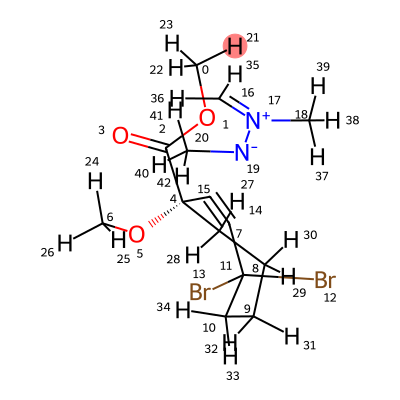

In [8]:
files[1][-1].rdmol

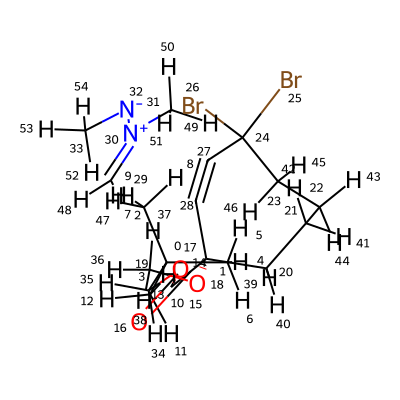

In [9]:
new_blocks[1].rdmol

Reset atom index in batches

MolOP parsing with single thread: 100%|██████████| 4/4 [00:01<00:00,  3.73it/s]
0 files failed to parse, 4 successfully parsed


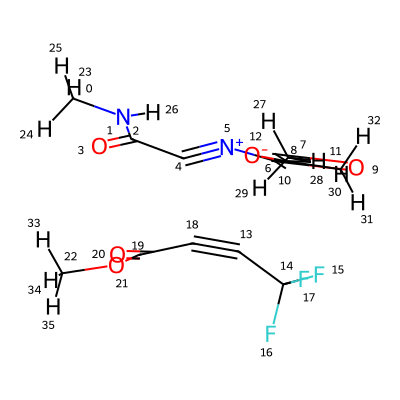

In [10]:
files = AutoParser("../tests/test_files/test_reset_index/*")
files[0][-1].rdmol

100%|██████████| 4/4 [00:00<00:00, 56.55it/s]
4 files successfully replaced, 0 files failed to reset_index


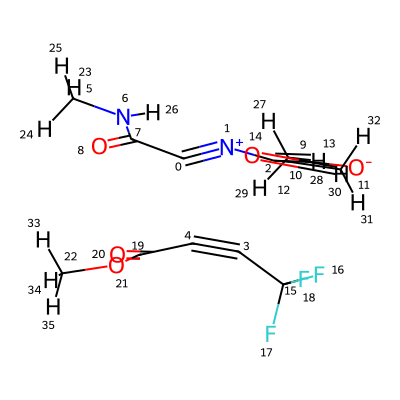

In [11]:
new_files = files.reset_atom_index(
    "[*^1,*^2]~[*+1^1,*+1^2]~[*+0^1,*+0^2].[C]#[C]")


new_files[0][-1].rdmol

In [12]:
new_files.to_summary_df()

,parser,file_name,file_path,file_format,charge,multiplicity,SMILES,status,ZPE,TCE,...,sp,HOMO,LUMO,GAP,first freq,first freq tag,second freq,second freq tag,S**2,S
0,SDFParser,TS_4cGKps_ll_ad_4-18_6-13_optts_g16_reindex.sdf,/home/tmj/proj/MolOP/tests/test_files/test_res...,.sdf,0,1,CNC(=O)C#[N+]/C(C(C)=O)=C(\C)[O-].COC(=O)C#CC(...,None,None,None,...,None,None,None,None,None,None,None,None,None,None
1,SDFParser,TS_4cGKps_ll_ad_4-18_6-13_sp_g16_reindex.sdf,/home/tmj/proj/MolOP/tests/test_files/test_res...,.sdf,0,1,CNC(=O)C#[N+]/C(C(C)=O)=C(\C)[O-].COC(=O)C#CC(...,None,None,None,...,None,None,None,None,None,None,None,None,None,None
2,SDFParser,TS_Zy0fwX_ll_ad_14-19_15-16_optts_g16_reindex.sdf,/home/tmj/proj/MolOP/tests/test_files/test_res...,.sdf,0,1,C=[N+](C)[N-]C.COC(=O)[C@@]1(OC)C#CC(Br)(Br)CCCC1,None,None,None,...,None,None,None,None,None,None,None,None,None,None
3,SDFParser,TS_ts_guess_FaFxyx_template_4-18_6-13_optts_co...,/home/tmj/proj/MolOP/tests/test_files/test_res...,.sdf,0,1,CNC(=O)C#[N+]/C(C(C)=O)=C(\C)[O-].COC(=O)C#CC(...,None,None,None,...,None,None,None,None,None,None,None,None,None,None


### Single file process

#### XYZ file TS with Metal and Radical

MolOP parsing with single thread: 100%|██████████| 1/1 [00:00<00:00, 352.34it/s]
0 files failed to parse, 1 successfully parsed


frame num: 1; atom num: 64
SMILES: CC(C)(C1=NCCO1)C1=NCCO1.C[C](C)N(C)C.[Cl-].[Cu+]c1ccc2ccccc2c1


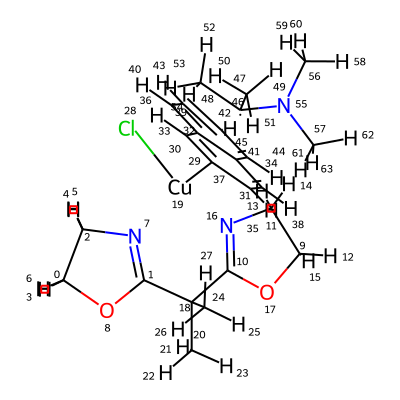

In [13]:
from molop import AutoParser

test_xyz_file = AutoParser(
    "../tests/test_files/xyz/test.xyz", charge=0, multiplicity=3)
print(f"frame num: {len(test_xyz_file)}; atom num: {len(test_xyz_file[0][0])}")
print(f"SMILES: {test_xyz_file[0][0].to_standard_SMILES()}")
test_xyz_file[0][0].rdmol

#### G16 LOG with Single Point

MolOP parsing with single thread: 100%|██████████| 1/1 [00:00<00:00, 64.72it/s]
0 files failed to parse, 1 successfully parsed


frame num: 1; atom num: 33
SMILES: CCC[C@H]1CO[C@H]2C[C@@](C)(O)C[C@@H]12
parameter comment: 
 %nprocshared=32  Will use up to   32 processors via shared memory.  %mem=100GB
 # def2tzvp m06l


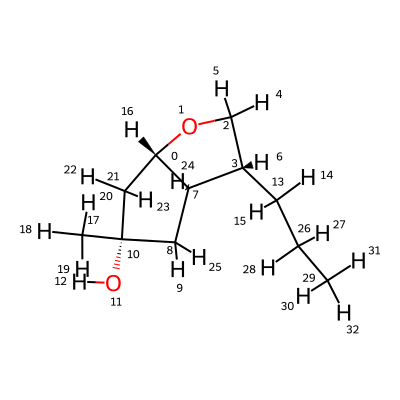

In [14]:
test_sp_file = AutoParser("../tests/test_files/g16log/3_Sp.log")
print(
    f"frame num: {len(test_sp_file[0])}; atom num: {len(test_sp_file[0][0])}")
print(f"SMILES: {test_sp_file[0][0].to_standard_SMILES()}")
print(f"parameter comment: \n{test_sp_file[0][0].parameter_comment}")
test_sp_file[0][0].rdmol

In [15]:
print(test_sp_file[0][0].energy)
test_sp_file[0][0].sum_energy

-581.780923 hartree / particle


{'zero-point gas': None,
 'E gas': None,
 'H gas': None,
 'G gas': None,
 'zero-point correction': None,
 'TCE': None,
 'TCH': None,
 'TCG': None}

In [16]:
print(f"partial charges num: {len(test_sp_file[0][0].partial_charges)}")
print(f"first 5: {test_sp_file[0][0].partial_charges[:5]}")

partial charges num: 33
first 5: [0.139353, -0.485914, 0.185647, 0.20812, 0.028079]


In [17]:
print(f"No freq No grdient: {test_sp_file[0][0].gradients}")

No freq No grdient: []


In [18]:
print(f"No freq parameter No freq: {test_sp_file[0][0].imaginary_frequencies}")
print(f"No freq parameter No freq: {test_sp_file[0][0].frequencies}")

No freq parameter No freq: []
No freq parameter No freq: []


In [19]:
print(test_sp_file[0][0].alpha_energy)
print(test_sp_file[0][0].beta_energy)

{'gap': <Quantity(0.24174, 'hartree / particle')>, 'homo': <Quantity(-0.21593, 'hartree / particle')>, 'lumo': <Quantity(0.02581, 'hartree / particle')>}
{'gap': None, 'homo': None, 'lumo': None}


#### G16 LOG with Opt

MolOP parsing with single thread: 100%|██████████| 1/1 [00:00<00:00,  9.34it/s]
0 files failed to parse, 1 successfully parsed


frame num: 13; atom num: 31
SMILES: C=C[C@H]1[C@@H]2[C@H](C[C@@]1(C)O)OC[C@@H]2C
parameter comment: 
 %nprocshared=32  Will use up to   32 processors via shared memory.  %mem=100GB
 # opt=maxcycle=150 freq def2svp m06l


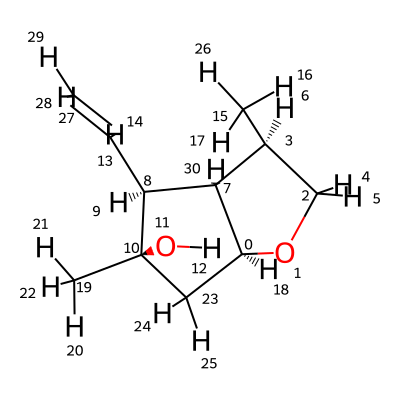

In [20]:
test_opt_file = AutoParser("../tests/test_files/g16log/11_Opt.log")
print(
    f"frame num: {len(test_opt_file[0])}; atom num: {len(test_opt_file[0][-1])}")
print(f"SMILES: {test_opt_file[0][-1].to_standard_SMILES()}")
print(f"parameter comment: \n{test_opt_file[-1].parameter_comment}")
test_opt_file[0][-1].rdmol

In [21]:
print(test_opt_file[0][-1].energy)
test_opt_file[0][-1].sum_energy

-579.925317 hartree / particle


{'zero-point gas': -579.649732 <Unit('hartree / particle')>,
 'E gas': -579.637414 <Unit('hartree / particle')>,
 'H gas': -579.63647 <Unit('hartree / particle')>,
 'G gas': -579.686912 <Unit('hartree / particle')>,
 'zero-point correction': 0.275585 <Unit('hartree / particle')>,
 'TCE': 0.287903 <Unit('hartree / particle')>,
 'TCH': 0.288847 <Unit('hartree / particle')>,
 'TCG': 0.238406 <Unit('hartree / particle')>}

In [22]:
print(f"partial charges num: {len(test_opt_file[0][-1].partial_charges)}")
print(f"first 5: {test_opt_file[0][-1].partial_charges[:5]}")

partial charges num: 31
first 5: [0.147998, -0.480978, 0.248552, -0.175483, 0.041544]


In [23]:
print(f"first 2 grdients: {test_opt_file[0][-1].gradients[:2]}")

first 2 grdients: [(<Quantity(-2.113e-06, 'hartree / bohr')>, <Quantity(4.623e-06, 'hartree / bohr')>, <Quantity(-3.46e-06, 'hartree / bohr')>), (<Quantity(-4.571e-06, 'hartree / bohr')>, <Quantity(6.814e-06, 'hartree / bohr')>, <Quantity(2.587e-06, 'hartree / bohr')>)]


In [24]:
print(f"No TS No imaginary frequencies: {test_opt_file[0][-1].imaginary_frequencies}")


print(f"first 1 freq: {test_opt_file[0][-1].frequencies[:1]}")

No TS No imaginary frequencies: []
first 1 freq: [{'is imaginary': False, 'freq': <Quantity(76.85, 'reciprocal_centimeter')>, 'reduced masses': <Quantity(3.0435, 'unified_atomic_mass_unit')>, 'force constants': <Quantity(0.0106, 'millidyne / angstrom')>, 'IR intensities': <Quantity(0.26, 'kilomole / mole')>, 'normal coordinates': <Quantity([[-0.01  0.01 -0.01]
 [ 0.02  0.04 -0.04]
 [-0.03  0.07 -0.06]
 [-0.09  0.02  0.01]
 [ 0.01  0.08 -0.09]
 [-0.08  0.1  -0.1 ]
 [-0.15  0.07  0.03]
 [-0.06 -0.01 -0.  ]
 [-0.05 -0.05  0.02]
 [-0.05 -0.08  0.03]
 [ 0.   -0.05  0.03]
 [ 0.01 -0.03  0.02]
 [ 0.01  0.    0.01]
 [-0.03 -0.02 -0.01]
 [-0.23 -0.14  0.02]
 [-0.09 -0.05  0.05]
 [-0.1  -0.08  0.08]
 [-0.1  -0.09  0.01]
 [-0.03  0.02 -0.02]
 [ 0.02 -0.09  0.05]
 [ 0.06 -0.08  0.07]
 [ 0.   -0.1   0.04]
 [ 0.02 -0.13  0.06]
 [ 0.02 -0.02  0.02]
 [ 0.01 -0.05  0.04]
 [ 0.06 -0.01  0.03]
 [-0.1  -0.04  0.1 ]
 [ 0.28  0.19 -0.09]
 [ 0.51  0.32 -0.12]
 [ 0.32  0.23 -0.12]
 [-0.08 -0.    0.  ]], 'angs

In [25]:
print(test_opt_file[0][-1].alpha_energy)
print(test_opt_file[0][-1].beta_energy)

{'gap': <Quantity(0.20428, 'hartree / particle')>, 'homo': <Quantity(-0.2188, 'hartree / particle')>, 'lumo': <Quantity(-0.01452, 'hartree / particle')>}
{'gap': None, 'homo': None, 'lumo': None}


#### G16 LOG with TS

MolOP parsing with single thread: 100%|██████████| 1/1 [00:00<00:00,  5.16it/s]
0 files failed to parse, 1 successfully parsed


frame num: 13; atom num: 47
SMILES: [Br-].[Br-].[Ni@OH26+3]c1ccccc1.[S-]Cc1ccccc1.c1c[nH]cn1.c1c[nH]cn1
parameter comment: 
 %nprocshared=32  Will use up to   32 processors via shared memory.  %mem=100GB
 # opt=(calcfc,ts,maxcycle=150,noeigen) freq ub3lyp/genecp empiricaldis  persion=gd3bj


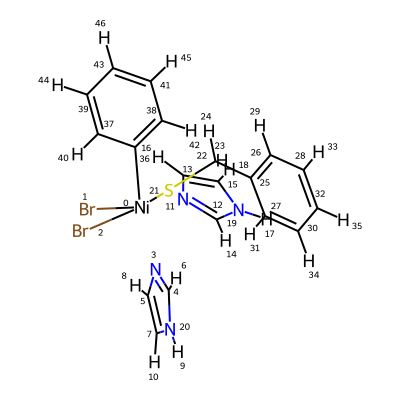

In [26]:
test_ts_file = AutoParser("../tests/test_files/g16log/S_Ph_Ni_TS.log")
print(
    f"frame num: {len(test_ts_file[0])}; atom num: {len(test_ts_file[0][-1])}")
print(f"SMILES: {test_ts_file[0][-1].to_standard_SMILES()}")
print(f"parameter comment: \n{test_ts_file[0][-1].parameter_comment}")
test_ts_file[0][-1].rdmol

In [27]:
print(test_ts_file[0][-1].energy)
test_ts_file[0][-1].sum_energy

-1549.05355 hartree / particle


{'zero-point gas': -1548.691989 <Unit('hartree / particle')>,
 'E gas': -1548.66487 <Unit('hartree / particle')>,
 'H gas': -1548.663926 <Unit('hartree / particle')>,
 'G gas': -1548.752428 <Unit('hartree / particle')>,
 'zero-point correction': 0.361561 <Unit('hartree / particle')>,
 'TCE': 0.38868 <Unit('hartree / particle')>,
 'TCH': 0.389624 <Unit('hartree / particle')>,
 'TCG': 0.301123 <Unit('hartree / particle')>}

In [28]:
print(f"partial charges num: {len(test_ts_file[0][-1].partial_charges)}")
print(f"first 5: {test_ts_file[0][-1].partial_charges[:5]}")

partial charges num: 47
first 5: [-0.275278, -0.2701, -0.195995, -0.374709, 0.238983]


In [29]:
print(f"first 2 grdients: {test_ts_file[0][-1].gradients[:2]}")

first 2 grdients: [(<Quantity(-2.53e-07, 'hartree / bohr')>, <Quantity(-3.125e-06, 'hartree / bohr')>, <Quantity(-6.649e-06, 'hartree / bohr')>), (<Quantity(5.86e-07, 'hartree / bohr')>, <Quantity(-1.071e-06, 'hartree / bohr')>, <Quantity(-5.85e-07, 'hartree / bohr')>)]


In [30]:
print(f"imaginary frequencies: {test_ts_file[0][-1].imaginary_frequencies}")
print(f"last 1 freq: {test_ts_file[0][-1].frequencies[-1:]}")

imaginary frequencies: [{'is imaginary': True, 'freq': <Quantity(-185.8656, 'reciprocal_centimeter')>, 'reduced masses': <Quantity(8.7628, 'unified_atomic_mass_unit')>, 'force constants': <Quantity(0.1784, 'millidyne / angstrom')>, 'IR intensities': <Quantity(37.9609, 'kilomole / mole')>, 'normal coordinates': <Quantity([[ 0.03  0.07 -0.07]
 [ 0.01 -0.01 -0.01]
 [-0.    0.01 -0.  ]
 [-0.05  0.07 -0.01]
 [-0.02  0.06  0.  ]
 [-0.03  0.06 -0.  ]
 [-0.01  0.07  0.01]
 [-0.    0.07  0.01]
 [-0.04  0.06 -0.  ]
 [ 0.03  0.07  0.02]
 [ 0.01  0.07  0.02]
 [ 0.02  0.01 -0.02]
 [ 0.02  0.01 -0.03]
 [-0.   -0.02  0.01]
 [ 0.04  0.04 -0.05]
 [-0.   -0.03  0.01]
 [-0.   -0.03  0.02]
 [ 0.01 -0.   -0.02]
 [-0.02 -0.05  0.02]
 [ 0.01 -0.01 -0.01]
 [ 0.    0.07  0.01]
 [ 0.11 -0.24 -0.11]
 [-0.03 -0.04  0.05]
 [-0.02  0.13  0.06]
 [-0.14 -0.1   0.17]
 [ 0.01 -0.01  0.  ]
 [ 0.   -0.    0.01]
 [ 0.02 -0.   -0.  ]
 [ 0.01  0.    0.  ]
 [-0.01 -0.01  0.01]
 [ 0.02  0.   -0.  ]
 [ 0.01 -0.    0.01]
 [ 0.0

In [31]:
print(test_ts_file[0][-1].alpha_energy)
print(test_ts_file[0][-1].beta_energy)

{'gap': <Quantity(0.07788, 'hartree / particle')>, 'homo': <Quantity(-0.18821, 'hartree / particle')>, 'lumo': <Quantity(-0.11033, 'hartree / particle')>}
{'gap': <Quantity(0.07788, 'hartree / particle')>, 'homo': <Quantity(-0.18821, 'hartree / particle')>, 'lumo': <Quantity(-0.11033, 'hartree / particle')>}
